### Modules

In [1]:
# basic
import os, sys, glob, pybedtools
import numpy as np, pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt, seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import fisher_exact

In [2]:
sys.path.insert(1, '/home/bo-yi/package/m6atm/m6atm/preprocess')
from ReadClass import *

In [3]:
sys.path.insert(1, '/home/bo-yi/package/m6atm/m6atm/train')
from ModelData import *

In [4]:
out_dir = '/home/bo-yi/paper'
data_dir = '/home/bo-yi/data/DRS/20211102_HepG2-WT/preprocessed'

tx_file = '/home/bo-yi/data/ref/enst_hg38Tables.tsv'
ref_tx = '/home/bo-yi/data/ref/GRCh38_rna_ensembl.fa'
ref_gn = '/home/bo-yi/data/ref/hg38.fa'

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Fig. 5

In [ ]:
# temp dir 
temp_dir = os.path.join(data_dir, 'temp')
os.makedirs(temp_dir, exist_ok = True)

In [ ]:
# # to bag
# bag_class = ATMbag(data_dir, processes = 24)
# bag_class.to_bag(temp_dir)

In [ ]:
# prediction
bag_data_list = sorted(glob.glob(os.path.join(temp_dir, 'bag_*.npy')))
bag_meta_list = sorted(glob.glob(os.path.join(temp_dir, 'site_*.csv')))

results = []
for f1, f2 in zip(bag_data_list, bag_meta_list):

    ### bags
    bag_data = np.load(f1, allow_pickle = True)
    bag_meta = pd.read_csv(f2, index_col = 0)

    ### dataloader
    dataset = WNBagloader(data = list(bag_data),
                          transform = transforms.Compose([ToTensor(device = 'cuda')]),
                          site = bag_meta['site'],
                          coverage = bag_meta['coverage'])

    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = False)

    ### prediction
    dsmil_pth = '/home/bo-yi/package/m6atm/m6atm/model/dsmil_ivt_20.pth'
    classifier_pth = '/home/bo-yi/package/m6atm/m6atm/model/classifer_ivt.pth'
    result = dsmil_pred(dsmil_pth, classifier_pth, dataloader, out_dir = temp_dir)
    results.append(result)

results = pd.concat(results, axis = 0)
results = results.reset_index(drop = True)

### save
results.to_csv(os.path.join(data_dir, 'results.csv'))

In [ ]:
tx_df = pd.read_csv(tx_file, sep = '\t')
tx_df['name'] = [i.split('.')[0] for i in tx_df['name']]
ref_dict_gn = get_ref_dict(ref_gn)

results_m6a = results[results.m6a == 'yes']
results_m6a_gn = tx_to_gn(results_m6a, tx_df, ref_dict_gn)

bed_table = results_m6a_gn.loc[:,['chrom', 'gn_pos', 'gn_pos_1', 'name2', 'ratio', 'strand']]
bed_table.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand']

bed_table.to_csv(os.path.join(data_dir, 'results.bed'), sep = '\t', index = None, header = None)

### Fig 5A

In [ ]:
tx_df = pd.read_csv(tx_file, sep = '\t')
tx_df['name'] = [i.split('.')[0] for i in tx_df['name']]
ref_dict_gn = get_ref_dict(ref_gn)

In [ ]:
all_table_tx = pd.read_csv(os.path.join(data_dir, 'results.csv'), index_col = 0)
all_table_gn = tx_to_gn(all_table_tx, tx_df, ref_dict_gn)
m6a_table_gn = all_table_gn[(all_table_gn.probability>=0.9) & (all_table_gn.coverage>=100)]

In [ ]:
### gene list 
file = open(os.path.join(data_dir, 'GO_genelist.txt'), 'w')
for gene in list(set(m6a_table_gn.name2)):
    
	file.write(gene + '\n')
    
file.close()

In [ ]:
GO_table = pd.read_csv(os.path.join(data_dir, 'GO.txt'), sep = '\t')

In [ ]:
### bar plot 
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette() # color palette
fig, ax = plt.subplots(figsize = (25, 6)) # figure size

### data
pval = GO_table.PValue[0:10]
terms = [i.split('~')[1] for i in GO_table.Term][0:10]
counts = GO_table['Count'][0:10]

### cmap
data_color = [x/max(pval) for x in pval]
my_cmap = plt.cm.get_cmap('viridis_r')
colors = my_cmap(data_color)

x = np.arange(len(terms))  # the label locations
width = 0.5  # the width of the bars

rects = ax.barh(x, counts, color = colors)
sm = ScalarMappable(cmap = my_cmap, norm = plt.Normalize(vmin = min(pval), vmax = max(pval)))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize = 20)
cbar.set_label('p-value ($10^{-5}$)', rotation = 270, labelpad = 40, fontsize = 28)

ax.set_xlabel('Counts', fontsize = 36)
ax.set_yticks(x)
ax.set_yticklabels(terms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.tick_params(labelsize = 25)

plt.savefig(os.path.join(out_dir, 'fig5a.png'), bbox_inches = 'tight', dpi = 300)

### Fig 5B

In [ ]:
def add_type(row, type_dict):
    
    tx = row['transcript']
    
    return type_dict[tx]

In [ ]:
### type dict
rnatype_dict = dict()
biotype_dict = dict()
for n, record in enumerate(SeqIO.parse(ref_TX, 'fasta')):
    info = record.description.split(' ')
    rnatype_dict[info[0].split('.')[0]] = info[1]
    biotype_dict[info[0].split('.')[0]] = info[5].split(':')[1]

In [ ]:
all_table_tx = pd.read_csv(os.path.join(data_dir, 'results.csv'), index_col = 0)
m6a_table_tx = all_table_tx[all_table_tx.probability>=0.9].copy()
m6a_table_tx['type'] = m6a_table_tx.apply(lambda x: add_type(x, biotype_dict), axis = 1)

In [ ]:
type_table = m6a_table_tx.groupby(by = 'type')['transcript'].count().reset_index(name = 'site')
type_table = type_table.sort_values(by = 'site', ascending = False)
others = pd.DataFrame({'type': 'others', 'site': type_table.iloc[4:,:].site.sum()}, index=[0])
type_table = pd.concat([type_table.iloc[:4,:], others])
values = type_table.site.tolist()

In [ ]:
### pie chart
sns.set_theme() # theme
fig, ax = plt.subplots(figsize = (8, 8)) # figure size

labels = type_table.type.tolist()
sizes = values
explode = [0, 0.1, 0.1, 0.1, 0]

ax.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 30, explode = explode, pctdistance = 1.2, labeldistance = None, 
       colors = sns.color_palette('Set2')[0:5], wedgeprops={'linewidth': 0.5})

fig.legend(labels, loc = 'upper right')

plt.savefig(os.path.join(out_dir, 'fig5b.png'), dpi = 300, bbox_inches = 'tight')

In [ ]:
### pie chart
sns.set_theme() # theme
fig, ax = plt.subplots(figsize = (8, 8)) # figure size

ax.pie(sizes, labels = labels, shadow = False, startangle = 30, explode = explode, labeldistance = None, 
       colors = sns.color_palette('Set2')[0:5], wedgeprops={'linewidth': 0.5})

fig.legend(labels, loc = 'upper right')

plt.savefig(os.path.join(out_dir, 'fig5b_nolabel.png'), dpi = 300, bbox_inches = 'tight')

### Fig 5C

In [ ]:
def get_region_bed(file, group):

    region = pd.read_csv(file, sep = '\t', header = None)
    region['region'] = group
    region = region.loc[:,[0, 1, 2, 'region']]
    region.columns = ['chrom', 'chromStart', 'chromEnd', 'region']
    
    return region

In [ ]:
all_table_tx = pd.read_csv(os.path.join(data_dir, 'results.csv'), index_col = 0)
m6a_table_tx = all_table_tx[all_table_tx.probability>=0.9].copy()

In [ ]:
tx_file = '/home/bo-yi/data/ref/enst_hg38Tables.tsv'
ref_tx = '/home/bo-yi/data/ref/GRCh38_rna_ensembl.fa'
ref_gn = '/home/bo-yi/data/ref/hg38.fa'

In [ ]:
tx_df = pd.read_csv(tx_file, sep = '\t')
tx_df['name'] = [i.split('.')[0] for i in tx_df['name']]
ref_dict_tx = get_ref_dict(ref_tx)
ref_dict_gn = get_ref_dict(ref_gn)

In [ ]:
m6a_table_gn = tx_to_gn(m6a_table_tx, tx_df, ref_dict_gn)
m6a_table_bed = m6a_table_gn.loc[:,['chrom', 'gn_pos', 'gn_pos_1', 'name2']]

In [ ]:
m6a_bed = pybedtools.BedTool.from_dataframe(df = m6a_table_bed)
utr3_bed = get_region_bed('/home/bo-yi/data/ref/tx_region/enst_3utr.tsv', '3\'UTR')
utr5_bed = get_region_bed('/home/bo-yi/data/ref/tx_region/enst_5utr.tsv', '5\'UTR')
exon_bed = get_region_bed('/home/bo-yi/data/ref/tx_region/enst_exons.tsv', 'Exon')
# intron_bed = get_region_bed('/home/bo-yi/data/ref/tx_region/enst_introns.tsv', 'Intron')
region_bed = pd.concat([utr3_bed, utr5_bed, exon_bed], axis = 0)
region_bed = pybedtools.BedTool.from_dataframe(df = region_bed)

m6a_bed_region = m6a_bed.intersect(region_bed, wa = True, wb = True)
m6a_bed_region = m6a_bed_region.to_dataframe()
m6a_bed_region = m6a_bed_region[~m6a_bed_region.loc[:,['chrom', 'start', 'end']].duplicated()]
m6a_bed_region = m6a_bed_region.rename({'thickEnd': 'region'}, axis = 1)
m6a_bed_region = m6a_bed_region.loc[:,['chrom', 'start', 'end', 'region']]

In [ ]:
m6a_table_gn = m6a_table_gn.merge(m6a_bed_region, how = 'inner', left_on = ['chrom', 'gn_pos', 'gn_pos_1'], right_on = ['chrom', 'start', 'end'])

In [ ]:
region_table = m6a_table_gn.groupby(by = 'region')['region'].count().reset_index(name = 'count')
region_table = region_table.sort_values(by = 'count', ascending = False)
values = region_table['count'].tolist()

In [ ]:
### pie chart
sns.set_theme() # theme
fig, ax = plt.subplots(figsize = (8, 8)) # figure size

labels = region_table.region.tolist()
sizes = values

ax.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = False, startangle = 30, pctdistance = 1.2, labeldistance = None, 
       colors = sns.color_palette()[0:3], wedgeprops={'linewidth': 0.5})

fig.legend(labels, loc = 'upper right')

plt.savefig(os.path.join(out_dir, 'fig5c.png'), dpi = 300, bbox_inches = 'tight')

In [ ]:
### pie chart
sns.set_theme() # theme
fig, ax = plt.subplots(figsize = (8, 8)) # figure size

ax.pie(sizes, labels = labels, shadow = False, startangle = 30, labeldistance = None, 
       colors = sns.color_palette()[0:3], wedgeprops={'linewidth': 0.5})

fig.legend(labels, loc = 'upper right')

plt.savefig(os.path.join(out_dir, 'fig5c_nolabel.png'), dpi = 300, bbox_inches = 'tight')

### Fig 5E

In [ ]:
tx_df = pd.read_csv(tx_file, sep = '\t')
tx_df['name'] = [i.split('.')[0] for i in tx_df['name']]
ref_dict_gn = get_ref_dict(ref_gn)

In [ ]:
all_table_tx = pd.read_csv(os.path.join(data_dir, 'results.csv'), index_col = 0)
all_table_gn = tx_to_gn(all_table_tx, tx_df, ref_dict_gn)
m6a_table_gn = all_table_gn[all_table_gn.probability>=0.9]

In [ ]:
with open (os.path.join(data_dir, 'motif.txt'), 'w') as f:
    for motif in m6a_table_gn['motif']:
        f.write(motif.replace('T', 'U')+'\n')

### Fig 5F

In [ ]:
gene_table = m6a_table_gn.groupby('name2', as_index = False).agg({'ratio': 'mean', 'gn_site': 'count', 'coverage': 'mean'})
gene_table = gene_table[gene_table.gn_site>=10]
gene_table = gene_table[gene_table.coverage>=50]
gene_table = gene_table.sort_values('ratio', ascending = False)

In [ ]:
##### main
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette() # color palette
fig, ax = plt.subplots(figsize = (20, 5)) # figure size

# data
top_genes = gene_table.name2[0:20].tolist()
top_df = m6a_table_gn[m6a_table_gn.name2.isin(top_genes)]
top_df = top_df.set_index('name2')
top_df = top_df.loc[top_genes]
top_df['name2'] = top_df.index

# plot
sns.boxplot(x = 'name2', y = 'ratio', data = top_df, width = 0.2,
            showmeans = True, meanprops = {'marker': 'P','markerfacecolor': 'yellow', 'markeredgecolor': 'black', 'markersize': '10'})
sns.stripplot(x = 'name2', y = 'ratio', data = top_df,
              hue = 'name2', size = 4, edgecolor = 'black', linewidth = 0.5, legend = False)

# Set transparancy for all box
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
    
ax.set_ylabel('m6A ratio', fontsize = 25)
ax.set(xlabel = None)
ax.tick_params(labelsize = 20)
plt.xticks(rotation = 45)

plt.savefig(os.path.join(out_dir, 'fig5f.png'), dpi = 300, bbox_inches = 'tight')

In [ ]:
##### main
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette() # color palette
fig, ax = plt.subplots(figsize = (25, 4)) # figure size

# data
top_genes = gene_table.name2[0:20].tolist()
top_df = m6a_table_gn[m6a_table_gn.name2.isin(top_genes)]
top_df = top_df.set_index('name2')
top_df = top_df.loc[top_genes]
top_df['name2'] = top_df.index

# plot
sns.boxplot(x = 'name2', y = 'ratio', data = top_df, width = 0.2,
            showmeans = True, meanprops = {'marker': 'P','markerfacecolor': 'yellow', 'markeredgecolor': 'black', 'markersize': '10'})
sns.stripplot(x = 'name2', y = 'ratio', data = top_df,
              hue = 'name2', size = 4, edgecolor = 'black', linewidth = 0.5, legend = False)

# Set transparancy for all box
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))
    
ax.set_ylabel('m6A ratio', fontsize = 25)
ax.set(xlabel = None)
ax.tick_params(labelsize = 20)
plt.xticks(rotation = 45)

plt.savefig(os.path.join(out_dir, 'fig5f_short.png'), dpi = 300, bbox_inches = 'tight')

### Fig 5G

#### m6A peaks 

In [6]:
tx_df = pd.read_csv(tx_file, sep = '\t')
tx_df['name'] = [i.split('.')[0] for i in tx_df['name']]
ref_dict_gn = get_ref_dict(ref_gn)

In [7]:
all_table_tx = pd.read_csv(os.path.join(data_dir, 'results.csv'), index_col = 0)
m6a_table_tx = all_table_tx[all_table_tx.m6a == 'yes']
m6a_table_gn = tx_to_gn(m6a_table_tx, tx_df, ref_dict_gn)
m6a_sites = m6a_table_gn.gn_site.tolist()

In [8]:
all_table_tx = pd.read_csv(os.path.join(data_dir, 'results.csv'), index_col = 0)
all_table_gn = tx_to_gn(all_table_tx, tx_df, ref_dict_gn)

In [9]:
peg10_df = all_table_gn.loc[all_table_gn['name2'] == 'PEG10',['chrom', 'gn_site', 'gn_pos', 'gn_pos_1', 'name2', 'probability', 'strand']]
peg10_df['m6a'] = peg10_df.gn_site.isin(m6a_sites)
peg10_df = peg10_df.loc[:,['chrom', 'gn_pos', 'gn_pos_1', 'name2', 'probability', 'strand', 'm6a']]
peg10_bedtools = pybedtools.BedTool.from_dataframe(df = peg10_df)

#### eCLIP data

In [10]:
names = ['chrom', 'chromStart', 'chromEnd', 'id', 'strand', 'name', 'exp', 'sample','accession']
rbp_bed = pd.read_csv('/home/bo-yi/data/ref/rbp38.txt', sep = '\t', header = None, names = names)
rbp_bed_hepg2_encode= rbp_bed[(rbp_bed['sample'].isin(['HepG2'])) & (rbp_bed['accession'].isin(['ENCODE']))]

In [11]:
rbp_list = sorted(list(set(rbp_bed_hepg2_encode.name)))

pval_list = []
or_list = []
val_list = []
for i in rbp_list:
    
    # eCLIP data
    eclip_bed = rbp_bed_hepg2_encode[rbp_bed_hepg2_encode['name'].isin([i])]
    eclip_bed = eclip_bed.loc[:,['chrom', 'chromStart', 'chromEnd', 'name']]
    eclip_bedtools = pybedtools.BedTool.from_dataframe(df = eclip_bed)
    
    # overlapping
    overlapping = peg10_bedtools.intersect(eclip_bedtools, wao = True)
    overlapping = overlapping.to_dataframe()
    overlapping = overlapping[~overlapping.loc[:,['chrom', 'start', 'end']].duplicated()]
    
    # frequency table
    val1 = overlapping[(overlapping['thickStart'] == True) & (overlapping['blockSizes'] == i)].shape[0]
    val2 = overlapping[(overlapping['thickStart'] == True) & (overlapping['blockSizes'] == '.')].shape[0]
    val3 = overlapping[(overlapping['thickStart'] == False) & (overlapping['blockSizes'] == i)].shape[0]
    val4 = overlapping[(overlapping['thickStart'] == False) & (overlapping['blockSizes'] == '.')].shape[0]
    
    # fisher test
    table = np.array([[val1, val2], [val3, val4]])
    res = fisher_exact(table, alternative = 'greater')
    
    pval_list.append(res[1])
    or_list.append(res[0])
    val_list.append([val1, val2, val3, val4])

In [12]:
val_list_zip = list(zip(*val_list))
result_table = pd.DataFrame({'rbp': rbp_list,
                             'odds': or_list,
                             'p_val': pval_list,
                             'val1': val_list_zip[0],
                             'val2': val_list_zip[1],
                             'val3': val_list_zip[2],
                             'val4': val_list_zip[3]})

In [13]:
result_table.sort_values(by = 'p_val', ascending = True).iloc[0:10]

,rbp,odds,p_val,val1,val2,val3,val4
94,UPF1,5.923077,0.002241,10,5,26,77
42,IGF2BP3,4.680000,0.007181,9,6,25,78
1,AKAP1,9.000000,0.009013,4,11,4,99
41,IGF2BP1,4.462585,0.010039,8,7,21,82
56,PCBP1,15.692308,0.042223,2,13,1,102
52,NKRF,3.015385,0.217388,2,13,5,98
16,DKC1,7.285714,0.239027,1,14,1,102
76,SND1,7.285714,0.239027,1,14,1,102
87,TIA1,1.895833,0.291112,3,12,12,91
29,G3BP1,1.407407,0.381653,5,10,27,76


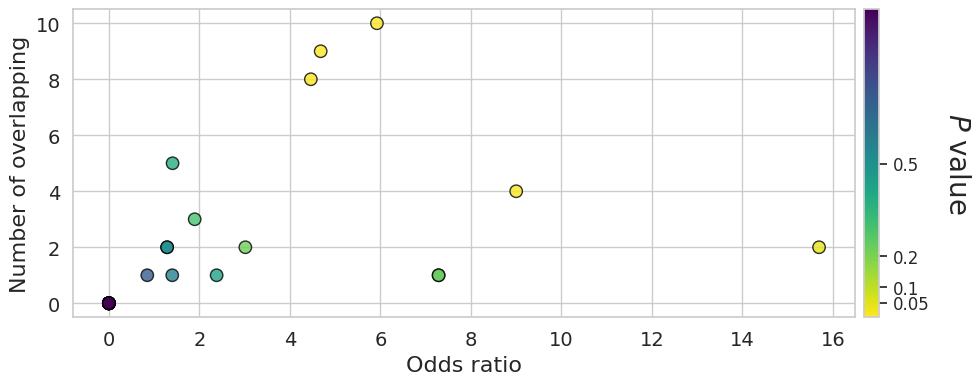

In [17]:
##### main
sns.set_theme(style = 'whitegrid') # theme
tab_color = sns.color_palette() # color palette
fig, ax = plt.subplots(figsize = (12, 4)) # figure size

### plot
scatter_table = result_table.dropna()
scatter = plt.scatter(scatter_table['odds'], scatter_table['val1'], c = scatter_table['p_val'], s = 80, cmap = 'viridis_r', alpha = 0.8, 
                      linewidth = 1, edgecolors = 'black')

# cmap
pval = scatter_table['p_val']
data_color = [x/max(pval) for x in pval]
my_cmap = plt.cm.get_cmap('viridis_r')
colors = my_cmap(data_color)

sm = ScalarMappable(cmap = my_cmap, norm = plt.Normalize(vmin = min(pval), vmax = max(pval)))
sm.set_array([])

cbar = plt.colorbar(sm, pad = 0.01, format = FormatStrFormatter('%g'))
cbar.ax.tick_params(labelsize = 12)
cbar.set_label('$\\mathit{P}$ value', rotation = 270, labelpad = 30, fontsize = 20)
cbar.set_ticks(ticks = [0.05, 0.1, 0.2, 0.5])

# axis
ax.set_xlabel('Odds ratio', fontsize = 16)
ax.set_ylabel('Number of overlapping', fontsize = 16)
ax.tick_params(labelsize = 14)

plt.savefig(os.path.join(out_dir, 'fig5g.png'), dpi = 300, bbox_inches = 'tight')

In [ ]:
### pie chart
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette('Set2') # color palette
fig, ax = plt.subplots(figsize = (8, 8)) # figure size

y1 = result_table[result_table.isna().any(axis=1)].shape[0]
y2 = scatter_table.shape[0]

labels = ['No overlap', '≥1 overlap']
sizes = [y1, y2]

ax.pie(sizes, labels = labels, explode = [0, 0.05], autopct = lambda x: int(np.round(x/100*sum(sizes), 0)),
       shadow = False, startangle = 80, labeldistance = None, colors = [tab_color[0], tab_color[6]], 
       textprops={'fontsize': 26, 'weight': 'bold'},
       wedgeprops={'linewidth': 0.5})

fig.legend(labels, loc = 'upper right', fontsize = 20)

plt.savefig(os.path.join(out_dir, 'figS6.tif'), dpi = 300, bbox_inches = 'tight')

#### Overlapping sites

In [ ]:
peg10_df = all_table_gn.loc[all_table_gn['name2'] == 'PEG10',['chrom', 'gn_site', 'gn_pos', 'gn_pos_1', 'name2', 'ratio', 'strand']]
peg10_df['m6a'] = peg10_df.gn_site.isin(m6a_sites)
peg10_df = peg10_df.loc[:,['chrom', 'gn_pos', 'gn_pos_1', 'name2', 'ratio', 'strand', 'm6a']]
peg10_bedtools = pybedtools.BedTool.from_dataframe(df = peg10_df)

In [ ]:
table_list = []
for i in ['IGF2BP1', 'IGF2BP3']:

    # eCLIP data
    eclip_bed = rbp_bed_hepg2_encode[rbp_bed_hepg2_encode['name'].isin([i])]
    eclip_bed = eclip_bed.loc[:,['chrom', 'chromStart', 'chromEnd', 'name']]
    eclip_bedtools = pybedtools.BedTool.from_dataframe(df = eclip_bed)

    # overlapping
    overlapping = peg10_bedtools.intersect(eclip_bedtools, wao = True)
    overlapping = overlapping.to_dataframe()
    overlapping = overlapping[~overlapping.loc[:,['chrom', 'start', 'end']].duplicated()]

    # frequency table
    site_table = overlapping[(overlapping['thickStart'] == True) & (overlapping['blockSizes'] == i)]
    table_list.append(site_table)
    
site_table_i = table_list[0].merge(table_list[1], on = ['chrom', 'start', 'end', 'score'])

In [ ]:
### to bedGraph
bedgraph = site_table_i.loc[:,['chrom', 'start', 'end', 'score']]
bedgraph.columns = ['chrom', 'chromStart', 'chromEnd', 'score']

with open(os.path.join(out_dir, 'peg10_overlap.bedGraph'), 'w') as f:

    f.write('track type=bedGraph name="ratio" description="m6ATM" color=238,31,137'+'\n')
    bedgraph.to_csv(f, sep = '\t', index = None, header = None)

In [ ]:
rbp_list = ['IGF2BP1', 'IGF2BP3']

pval_list = []
or_list = []
val_list = []
for i in rbp_list:
    
    # eCLIP data
    eclip_bed = rbp_bed_hepg2_encode[rbp_bed_hepg2_encode['name'].isin([i])]
    eclip_bed = eclip_bed.loc[:,['chrom', 'chromStart', 'chromEnd', 'name']]
    eclip_bedtools = pybedtools.BedTool.from_dataframe(df = eclip_bed)
    
    # overlapping
    overlapping = peg10_bedtools.intersect(eclip_bedtools, wao = True)
    overlapping = overlapping.to_dataframe()
    overlapping = overlapping[~overlapping.loc[:,['chrom', 'start', 'end']].duplicated()]
    
    # frequency table
    val1 = overlapping[(overlapping['thickStart'] == True) & (overlapping['blockSizes'] == i)].shape[0]
    val2 = overlapping[(overlapping['thickStart'] == True) & (overlapping['blockSizes'] == '.')].shape[0]
    val3 = overlapping[(overlapping['thickStart'] == False) & (overlapping['blockSizes'] == i)].shape[0]
    val4 = overlapping[(overlapping['thickStart'] == False) & (overlapping['blockSizes'] == '.')].shape[0]
    
    # fisher test
    table = np.array([[val1, val2], [val3, val4]])
    res = fisher_exact(table, alternative = 'greater')
    
    pval_list.append(res[1])
    or_list.append(res[0])
    val_list.append([val1, val2, val3, val4])

In [ ]:
##### main
sns.set_theme(style = 'white') # theme
tab_color = sns.color_palette('Set2') # color palette
fig, ax = plt.subplots(figsize = (2, 6)) # figure size

### plot
scatter_table = result_table.dropna()
x = ['RBPs']
y1 = result_table[result_table.isna().any(axis=1)].shape[0]
y2 = scatter_table.shape[0]


ax.bar(x, y1, label = 'No overlapping', align = 'center', width = 0.6, color = tab_color[0])
ax.bar(x, y2, bottom = y1, label = '≥1 DRACH site \noverlapping', align = 'center', width = 0.6, color = tab_color[6])

ax.legend(bbox_to_anchor = (1, 1), fontsize = 14)

# text
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_y() + bar.get_height()/2,
            bar.get_height(),
            ha = 'center',
            color = 'black',
            weight = 'bold',
            size = 20)

# axis
ax.set_xlim(-0.5, 0.5)
ax.set_ylabel('Count', fontsize = 20)
ax.tick_params(labelsize = 16)

plt.savefig(os.path.join(out_dir, 'fig5g_supp.png'), dpi = 300, bbox_inches = 'tight')

In [ ]:
bed_rbp_hepg2 = bed_rbp[(bed_rbp['sample'].isin(['HepG2'])) & (bed_rbp['name'].isin(m6abp))]
# bed_rbp_hepg2 = bed_rbp_hepg2.loc[:,['chrom', 'chromStart', 'chromEnd', 'name']]
# bed_rbp_hepg2.to_csv(os.path.join(out_dir, 'rbp_class1_hepg2.bed'), sep = '\t', index = None, header = None)

In [ ]:
bed_rbp_igf2bp1 = bed_rbp[(bed_rbp['sample'].isin(['HepG2'])) & (bed_rbp['name'].isin(['IGF2BP1']))]
bed_rbp_igf2bp1 = bed_rbp_igf2bp1.loc[:,['chrom', 'chromStart', 'chromEnd', 'name']]
bed_rbp_igf2bp1.to_csv(os.path.join(out_dir, 'eclip_igf2bp1_hepg2.bed'), sep = '\t', index = None, header = None)

In [ ]:
bed_rbp_igf2bp3 = bed_rbp[(bed_rbp['sample'].isin(['HepG2'])) & (bed_rbp['name'].isin(['IGF2BP3']))]
bed_rbp_igf2bp3 = bed_rbp_igf2bp3.loc[:,['chrom', 'chromStart', 'chromEnd', 'name']]
bed_rbp_igf2bp3.to_csv(os.path.join(out_dir, 'eclip_igf2bp3_hepg2.bed'), sep = '\t', index = None, header = None)

In [ ]:
bed_rbp_hnrnpc = bed_rbp[(bed_rbp['sample'].isin(['HepG2'])) & (bed_rbp['name'].isin(['HNRNPC']))]
bed_rbp_hnrnpc = bed_rbp_hnrnpc.loc[:,['chrom', 'chromStart', 'chromEnd', 'name']]
bed_rbp_hnrnpc.to_csv(os.path.join(out_dir, 'eclip_hnrnpc_hepg2.bed'), sep = '\t', index = None, header = None)